In [202]:
import os
import sys
import time
import math
import argparse
from dataclasses import dataclass
from typing import List

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [203]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

words = load_data('lines.txt')
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [204]:
class CharDataset(Dataset):
    def __init__(self, words, chars, max_word_length):
        self.words = words
        self.chars = chars
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()}

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.chars) + 1

    def get_output_length(self):
        return self.max_word_length + 1

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 

        return x, y

class RNNCell(nn.Module):
    """
    the job of a 'Cell' is to:
    take input at current time step x_{t} and the hidden state at the
    previous time step h_{t-1} and return the resulting hidden state
    h_{t} at the current timestep
    """
    def __init__(self, config):
        super().__init__()
        # self.wxh_to_h = torch.randn(config.n_embd + config.n_embd2, config.n_embd2) * 5/3 / math.sqrt(config.n_embd + config.n_embd2)
        # self.bxh_to_h = torch.zeros(config.n_embd2) * 0
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        # ht = torch.tanh(xh @ self.wxh_to_h + self.bxh_to_h)
        ht = torch.tanh(self.xh_to_h(xh))
        return ht

class RNN(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.cell = RNNCell(config)
        self.out_cell = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        b, t = idx.size()

        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        emb = self.wte(idx)
        hprev = self.start.expand((b, -1))
        hiddens = []

        for i in range(t):
            xt = emb[:, i, :]
            ht = self.cell(xt, hprev)
            hprev = ht
            hiddens.append(ht)

        hidden = torch.stack(hiddens, 1)
        logits = self.out_cell(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

def train_rnn(model, batch_loader, epochs=50000, learning_rate=0.01):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=learning_rate, 
                                weight_decay=0.01, 
                                betas=(0.9, 0.99), 
                                eps=1e-8)
    all_losses = []
    all_iters = []
    
    for epoch in range(epochs):
        batch = batch_loader.next()
        X, Y = batch

        # feed into the model
        _, loss = model(X, Y)

        # backprop
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"step {epoch} | loss {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters

def create_datasets(input_file):
    words = open(input_file, 'r').read().splitlines()
    words = preprocessing(words)
    words = [w.replace("/", "").replace("$", "").replace("  ", " ").strip() for w in words] 
    words = [w for w in words if w]
    chars = sorted(list(set(''.join(words))))
    max_word_length = max(len(w) for w in words)
    
    test_set_size = min(1000, int(len(words) * 0.1))
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset


In [205]:
class InfiniteDataLoader:
    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

@dataclass
class ModelConfig:
    block_size: int = None
    vocab_size: int = None
    n_embd: int = 64
    n_embd2: int = 64

train_dataset, test_dataset = create_datasets("lines.txt")
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
config = ModelConfig(vocab_size=vocab_size, block_size=block_size)

print(f"vocab size: {vocab_size}")
print(f"block size: {block_size}")

batch_loader = InfiniteDataLoader(train_dataset, batch_size=32)
model = RNN(config)
all_losses, all_iters = train_rnn(model, batch_loader, epochs=1000)

split up the dataset into 10235 training examples and 1000 test examples
vocab size: 31
block size: 118
step 0 | loss 3.4464
step 10 | loss 2.4829
step 20 | loss 2.3237
step 30 | loss 2.2231
step 40 | loss 2.1932
step 50 | loss 2.1864
step 60 | loss 2.1486
step 70 | loss 2.1351
step 80 | loss 2.0901
step 90 | loss 2.0470
step 100 | loss 2.0902
step 110 | loss 2.0265
step 120 | loss 1.9970
step 130 | loss 1.9396
step 140 | loss 1.9679
step 150 | loss 2.0339
step 160 | loss 1.9207
step 170 | loss 1.9942
step 180 | loss 1.8931
step 190 | loss 1.9543
step 200 | loss 1.9358
step 210 | loss 1.8869
step 220 | loss 1.9373
step 230 | loss 1.8877
step 240 | loss 1.9777
step 250 | loss 1.9421
step 260 | loss 1.8284
step 270 | loss 1.8490
step 280 | loss 1.9186
step 290 | loss 1.9197
step 300 | loss 1.8642
step 310 | loss 1.9029
step 320 | loss 1.8691
step 330 | loss 1.8266
step 340 | loss 1.8763
step 350 | loss 1.8372
step 360 | loss 1.8662
step 370 | loss 1.8395
step 380 | loss 1.8812
step 390 |

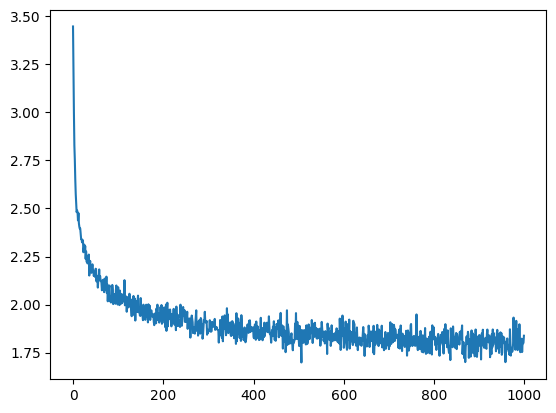

In [206]:
plt.plot(all_iters, all_losses)

In [207]:
# test out the model
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
batch = next(iter(test_loader))
X, Y = batch
logits, loss = model(X, Y)
print("loss", loss.item())

loss 1.8994473218917847


## Comparable loss to Single Layer NN -> which is weird cause RNN is supposed to do better?

In [225]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num=10):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = None
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(model, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", " "))
    print('-'*80)


print_samples(num=10)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
somels now i
the conswalied leaven my is to the bips a emodin
hup be away lead of now
oceh sackled tree moine pill to sky honeacig'
the of i grair due too soxay ite misch tries your off now offatcer verys take some of never look than conted you you
sky mathine on gay no at haisy too to be
minding time me but and youg the bad in toikled huld one
the life nog a dear gives
my loors a death cads cheared overy a bive'p nother out my she snimbor blied of me abrous know
hea the rivere lack no shopes you shine a timench to gelling tat crying thathed you kn turns light i he we grise aut
--------------------------------------------------------------------------------
